In [1]:
from random import randint as rand
from IPython.display import Image as Img
from matplotlib import pyplot as plt

In [2]:
import config
config.configure_imports()

from Map import Map
from Node import Node
from Change import Change
from LPAStar import LPAStar
from a_star import a_star

from visualizer import *
from data_parser import *

In [3]:
lak105d_filename = '../data/lak105d.map'
lak105d_scen_filename = '../data/lak105d.map.scen'
den204d_filename = '../data/den204d.map'
den204d_scen_filename = '../data/den204d.map.scen'
den312d_filename = '../data/den312d.map'
den312d_scen_filename = '../data/den312d.map.scen'

In [4]:
def massive_test_no_changes(map_filename, scen_filename, n_tasks = None):
    _map = Map()
    _map.read_from_string(*read_map(map_filename))
    tasks = read_map_scen(scen_filename, n_tasks)

    for start_i, start_j, goal_i, goal_j, _ in tasks:
        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)

        lpa_star = LPAStar(_map, start, finish)
        assert len(lpa_star.greedy_path()) - 1 == a_star(_map, start, finish)

    print('all tests passed')

In [5]:
massive_test_no_changes(lak105d_filename, lak105d_scen_filename)

all tests passed


In [6]:
def massive_test_with_changes(map_filename, scen_filename, n_tasks = None, n_changes = 10):
    for start_i, start_j, goal_i, goal_j, _ in read_map_scen(scen_filename, n_tasks):
        _map, _map_a = Map(), Map()
        _map.read_from_string(*read_map(map_filename))
        _map_a.read_from_string(*read_map(map_filename))

        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)

        lpa_paths = []
        for _ in range(n_changes):
            true_result = a_star(_map_a, start, finish)
            if true_result == -1:
                break

            lpa_star = LPAStar(_map, start, finish)
            lpa_path = lpa_star.greedy_path()
            lpa_paths.append(lpa_path)
            lpa_result = len(lpa_path) - 1
        
            assert lpa_result == true_result, f'{lpa_result} {true_result}'

            if len(lpa_path) < 3:
                break

            index = rand(1, len(lpa_path) - 1)
            qi, qj = lpa_path[index].coordinates()

            lpa_star.apply_changes([Change(0, qi, qj, True)])
            _map_a.apply_change(Change(0, qi, qj, True))

    print('all tests passed')

In [7]:
massive_test_with_changes(lak105d_filename, lak105d_scen_filename)

all tests passed


In [8]:
def run_on(map_filename, start, finish, pixel_size = 20, gif_speed = 200, n_changes=inf):
    _map, _mmap = Map(), Map()
    _map.read_from_string(*read_map(map_filename))
    _mmap.read_from_string(*read_map(map_filename))

    lpa_paths = [[start, finish]]
    lpa_visiteds = [[]]
    obstacles = [[]]

    lpa_star = LPAStar(_map, start, finish)

    for _ in range(n_changes):
        lpa_path = lpa_star.greedy_path()
        if lpa_path is None:
            break
        lpa_paths.append(lpa_path)

        if len(lpa_path) < 3:
            break

        index = rand(1, len(lpa_path) - 2)
        qi, qj = lpa_path[index].coordinates()
        obstacles.append(obstacles[-1] + [Node(qi, qj)])
        
        lpa_visited = lpa_star.apply_changes([Change(0, qi, qj, True)])
        lpa_visiteds.append(lpa_visited)
    
    gif_filename = f'lpa_star_{start.i}_{start.j}_{finish.i}_{finish.j}.gif'
    draw_fast_paths(_mmap, lpa_paths, obstacles, lpa_visiteds, gif_filename, pixel_size, gif_speed)
    return Img(filename=gif_filename)

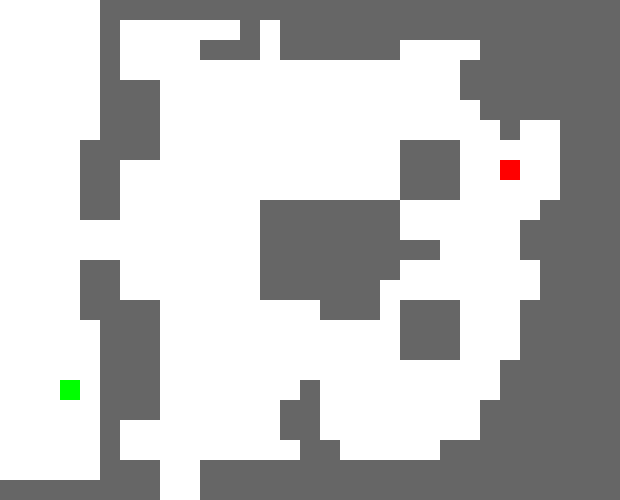

In [9]:
run_on(lak105d_filename, Node(8, 25), Node(19, 3), 20, 1000)

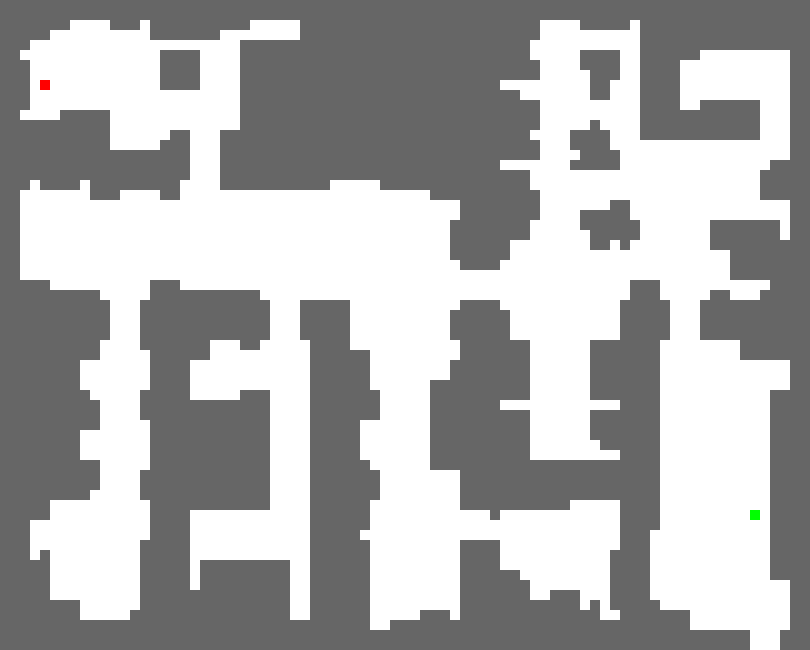

In [10]:
run_on(den312d_filename, Node(8, 4), Node(51, 75), 10, 1000)

In [11]:
def compare_lpa_a_star(map_filename, scen_filename, n_tasks = None, n_changes = 10):
    lpa_visiteds = []
    a_star_visiteds = []
    for start_i, start_j, goal_i, goal_j, _ in read_map_scen(scen_filename, n_tasks):
        _map, _map_a = Map(), Map()
        _map.read_from_string(*read_map(map_filename))
        _map_a.read_from_string(*read_map(map_filename))

        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)

        lpa_paths = []
        for _ in range(n_changes):
            true_result, a_star_visited = a_star(_map_a, start, finish, return_visited=True)
            if true_result == -1:
                break
            a_star_visiteds.append(len(a_star_visited))

            lpa_star = LPAStar(_map, start, finish)
            lpa_path = lpa_star.greedy_path()
            lpa_paths.append(lpa_path)
            lpa_result = len(lpa_path) - 1
        
            assert lpa_result == true_result, f'{lpa_result} {true_result}'

            if len(lpa_path) < 3:
                break

            index = rand(1, len(lpa_path) - 1)
            qi, qj = lpa_path[index].coordinates()

            lpa_visited = lpa_star.apply_changes([Change(0, qi, qj, True)])
            lpa_visiteds.append(len(lpa_visited))
            _map_a.apply_change(Change(0, qi, qj, True))

    print('all tests passed')
    return lpa_visiteds, a_star_visiteds

In [14]:
lpa_lak_v, a_lak_v = compare_lpa_a_star(lak105d_filename, lak105d_scen_filename)

all tests passed


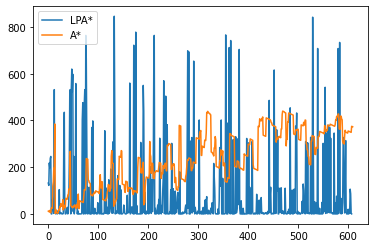

In [17]:
_, ax = plt.subplots(1, 1)
ax.plot(lpa_lak_v, label='LPA*')
ax.plot(a_lak_v, label='A*')
ax.legend()
plt.show()

In [ ]:
# lpa_v, a_v = compare_lpa_a_star(den312d_filename, den312d_scen_filename)